In [ ]:
''''
#### CDS pricing ####

0. Merge CDS data with CRSP-Compustat data based on gvkey and date. 
1. Keep only numerical variables.
2. Impute missing values with 0.
3. Remove variables that are all missing.
4. Divide the dataset to test (20%) and train (80%).
5. Run a Random Forest with 50 trees on train dataset.
6. Keep the first 50 features with highest feature importances and discard the rest from both test and train.
7. Use these 50 variables to run Random Forest, Gradient Boosting, and XGBoost with 100, 200, 500, and 1000 trees.
8. plot the relationship between number of trees and "Mean Squared Error" of test sample in a line graph.

''''

In [2]:
import pandas as pd
import numpy as np

In [2]:
# read CRSP-compustat file and add columns of 'year' and 'month' to help create the 'period' for merging
WRDSdata = pd.read_csv('Quarterly Merged CRSP-Compustat.csv')

WRDSdata.columns = map(str.lower, WRDSdata.columns)

WRDSdata['year'] = pd.DatetimeIndex(WRDSdata['datadate']).year
WRDSdata['month'] = pd.DatetimeIndex(WRDSdata['datadate']).month

WRDSdata['quarter'] = np.where( WRDSdata['month'].isin([1,2,3]), 'Q1', '')
WRDSdata['quarter'] = np.where( WRDSdata['month'].isin([4,5,6]), 'Q2', WRDSdata['quarter'])
WRDSdata['quarter'] = np.where( WRDSdata['month'].isin([7,8,9]), 'Q3', WRDSdata['quarter'])
WRDSdata['quarter'] = np.where( WRDSdata['month'].isin([10,11,12]), 'Q4', WRDSdata['quarter'])
WRDSdata['match_period'] = WRDSdata['year'].astype(str) + WRDSdata['quarter']

WRDSdata.head(5)

C:\Users\duck7\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,17,19,20,24,25,27,32,33,37,39,40,41,42,654,655,656,657,661,663,671,675,676,681,682,686) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gvkey,linkprim,liid,linktype,lpermno,lpermco,linkdt,linkenddt,datadate,fyearq,...,spcsrc,state,stko,weburl,dldte,ipodate,year,month,quarter,match_period
0,1004,P,1,LU,54594,20000,04/24/1972,E,11/30/2000,2000,...,B,IL,0.0,www.aarcorp.com,NaN,01/01/1988,2000,11,Q4,2000Q4
1,1004,P,1,LU,54594,20000,04/24/1972,E,02/28/2001,2000,...,B,IL,0.0,www.aarcorp.com,NaN,01/01/1988,2001,2,Q1,2001Q1
2,1004,P,1,LU,54594,20000,04/24/1972,E,05/31/2001,2000,...,B,IL,0.0,www.aarcorp.com,NaN,01/01/1988,2001,5,Q2,2001Q2
3,1004,P,1,LU,54594,20000,04/24/1972,E,08/31/2001,2001,...,B,IL,0.0,www.aarcorp.com,NaN,01/01/1988,2001,8,Q3,2001Q3
4,1004,P,1,LU,54594,20000,04/24/1972,E,11/30/2001,2001,...,B,IL,0.0,www.aarcorp.com,NaN,01/01/1988,2001,11,Q4,2001Q4


In [3]:
# divide the firms into three lists: 'type1', 'type2' and 'type3'
# type 1: firms with months of quaters ends at 1,4,7,10 in CRSP-compustat file
# type 2: firms with months of quaters ends at 2,5,8,11 in CRSP-compustat file
# type 3: firms with months of quaters ends at 3,6,9,12 in CRSP-compustat file
# later based on these lists we divide the firms in CDS file into 4 sub-dataframes: type1, type2, type3 and other
s = WRDSdata[['gvkey','month']]
s = s.drop_duplicates(subset='gvkey', keep='first')

s1 = s.loc[s['month'].isin([1,4,7,10])]
s2 = s.loc[s['month'].isin([2,5,8,11])]
s3 = s.loc[s['month'].isin([3,6,9,12])]

type1 = s1['gvkey'].tolist()
type2 = s2['gvkey'].tolist()
type3 = s3['gvkey'].tolist()
alltype = WRDSdata['gvkey'].unique().tolist()

print(len(type1)+len(type2)+len(type3))
print(len(alltype))

13236
13236


In [4]:
# read the CDS file and add columns of 'year' and 'month'
data = pd.io.stata.read_stata('cds_spread5y_2001_2016.dta')
data.to_csv('cds_spread5y_2001_2016.csv')
cdsdata = pd.read_csv('cds_spread5y_2001_2016.csv')

cdsdata['year'] = pd.DatetimeIndex(cdsdata['mdate']).year
cdsdata['month'] = pd.DatetimeIndex(cdsdata['mdate']).month
cdsdata.head(5)

,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,year,month
0,0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.042000,BB,2004,8
1,1,1038,2005-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034000,BB,2005,8
2,2,1038,2005-09-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034000,BB,2005,9
3,3,1038,2005-10-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034001,BB,2005,10
4,4,1038,2005-11-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034001,BB,2005,11


In [5]:
# divide the firms in CDS file by type1, type2, type3 and other
df1 = cdsdata[cdsdata['gvkey'].isin(type1)].reset_index() # by type1
df2 = cdsdata[cdsdata['gvkey'].isin(type2)].reset_index() # by type2
df3 = cdsdata[cdsdata['gvkey'].isin(type3)].reset_index() # by type3
df4 = cdsdata[~cdsdata['gvkey'].isin(alltype)].reset_index() # the rest

print(len(df1)+len(df2)+len(df3)+len(df4) == len(cdsdata))
print(len(cdsdata))

True
169043


In [6]:
# create column 'match_period' for later merging 
df1['quarter'] = np.where( df1['month'].isin([1,2,3]), 'Q1', '')
df1['quarter'] = np.where( df1['month'].isin([4,5,6]), 'Q2', df1['quarter'])
df1['quarter'] = np.where( df1['month'].isin([7,8,9]), 'Q3', df1['quarter'])
df1['quarter'] = np.where( df1['month'].isin([10,11,12]), 'Q4', df1['quarter'])
df1['match_period'] = df1['year'].astype(str) + df1['quarter']

# merge the sub-dataframe of type1 with WRDSdata
df1_merged = pd.merge(df1, WRDSdata, on=['gvkey','match_period'], how='left')
df1_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,1545,1545,1240,2002-01-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005400,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1
1,1546,1546,1240,2002-02-28,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005583,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1
2,1547,1547,1240,2002-03-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005188,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1


In [7]:
# create column 'match_period' for merging later
df2['quarter'] = np.where( df2['month'].isin([2,3,4]), 'Q1', '')
df2['quarter'] = np.where( df2['month'].isin([5,6,7]), 'Q2', df2['quarter'])
df2['quarter'] = np.where( df2['month'].isin([8,9,10]), 'Q3', df2['quarter'])
df2['quarter'] = np.where( df2['month'].isin([11,12,1]), 'Q4', df2['quarter'])
df2['year'] = np.where( df2['month']==1, df2['year']-1, df2['year'])
df2['match_period'] = df2['year'].astype(str) + df2['quarter']

# merge the sub-dataframe by type2 with WRDSdata
df2_merged = pd.merge(df2, WRDSdata, on=['gvkey','match_period'], how='left')
df2_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,3446,3446,1468,2003-03-31,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.034447,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,2.0,Q1
1,3447,3447,1468,2003-05-31,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.032660,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,5.0,Q2
2,3448,3448,1468,2003-06-30,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.028160,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,5.0,Q2


In [8]:
# create column 'match_period' for merging later
df3['quarter'] = np.where( df3['month'].isin([3,4,5]), 'Q1', '')
df3['quarter'] = np.where( df3['month'].isin([6,7,8]), 'Q2', df3['quarter'])
df3['quarter'] = np.where( df3['month'].isin([9,10,11]), 'Q3', df3['quarter'])
df3['quarter'] = np.where( df3['month'].isin([12,1,2]), 'Q4', df3['quarter'])
df3['year'] = np.where( df3['month'].isin([1,2]), df3['year']-1, df3['year'])
df3['match_period'] = df3['year'].astype(str) + df3['quarter']

# merge the sub-dataframe by type3 with WRDSdata
df3_merged = pd.merge(df3, WRDSdata, on=['gvkey','match_period'], how='left')
df3_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,0,0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.042,...,978.0,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2004.0,6.0,Q2
1,1,1,1038,2005-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,1038,2005-09-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# create column 'match_period' for merging later
df4['quarter'] = np.where( df4['month'].isin([1,2,3]), 'Q1', '')
df4['quarter'] = np.where( df4['month'].isin([4,5,6]), 'Q2', df4['quarter'])
df4['quarter'] = np.where( df4['month'].isin([7,8,9]), 'Q3', df4['quarter'])
df4['quarter'] = np.where( df4['month'].isin([10,11,12]), 'Q4', df4['quarter'])
df4['match_period'] = df4['year'].astype(str) + df4['quarter']

# merge the sub-dataframe by type4 with WRDSdata
df4_merged = pd.merge(df4, WRDSdata, on=['gvkey','match_period'], how='left')
df4_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,1241,1241,1225,2004-12-31,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1242,1242,1225,2005-01-31,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1243,1243,1225,2005-02-28,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# combine all the sub-dataframe together
final = pd.concat([df1_merged, df2_merged, df3_merged, df4_merged], ignore_index=True)

# drop the temporary columns
final = final.drop(['index','Unnamed: 0','year_y','month_y','quarter_y','year_x','month_x','quarter_x','match_period'], axis=1)

#final.to_csv('cds_combined_with_CRSPdata.csv', encoding='utf-8', index=False)
final.head(5)

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,linkprim,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1240,2002-01-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005400,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
1,1240,2002-02-28,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005583,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
2,1240,2002-03-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005188,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
3,1240,2002-04-30,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005355,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
4,1240,2002-05-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005242,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN


In [11]:
# Drop useless variables
mydata = final.drop(['gvkey','mdate','redcode','tier','ticker','shortname','docclause','linkprim','liid','linktype',
                      'lpermno','lpermco','linkdt','linkenddt','datadate','fyearq','fqtr','fyr','indfmt','consol',
                      'popsrc','datafmt','tic','cusip','conm','acctchgq','acctstdq','adrrq','ajexq','ajpq','bsprq',
                      'compstq','curcdq','curncdq','currtrq','curuscnq','datacqtr','datafqtr','finalq','ogmq','rp',
                      'scfq','srcq','staltq','updq','apdedateq','fdateq','pdateq','rdq','exchg','fic','adjex','add1',
                      'add2','add3','add4','addzip','busdesc','city','conml','county','dlrsn','ein','fax','fyrc','ggroup',
                      'gind','gsector','gsubind','idbflag','incorp','loc','naics','phone','prican','prirow','priusa','sic',
                      'spcindcd','spcseccd','state','stko','weburl','dldte','ipodate','impliedrating','spcsrc'], axis=1)    

# Remove variables that are all missing
mydata = mydata.dropna(axis='columns',how='all')

# Impute missing values with median
mydata = mydata.fillna(0)

# Drop duplicates
mydata = mydata.drop_duplicates(keep='first')

# Keep only numerical variables
mydata = mydata._get_numeric_data()


#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
## LabelEncoder: encoded a set of names into numerical data (still categorical data)
#labelencoder_X_impliedrating = LabelEncoder() 
#X[:, 0] = labelencoder_X_impliedrating.fit_transform(X[:, 0].astype(str))
#labelencoder_X_spcsrc = LabelEncoder()
#X[:, -1] = labelencoder_X_spcsrc.fit_transform(X[:, -1].astype(str))
## OneHotEncoder: convert the column with higher than 1 into mutiple columns with only 0 and 1
#onehotencoder_impliedrating = OneHotEncoder(categorical_features = [0])
#X = onehotencoder_impliedrating.fit_transform(X).toarray()
#X = X[:,0:] #remove the redundancy
#onehotencoder_spcsrc = OneHotEncoder(categorical_features = [-1])
#X = onehotencoder_spcsrc.fit_transform(X).toarray()
#X = X[:,:-1] #remove the redundancy

In [12]:
print(mydata.shape)

(110256, 607)


In [13]:
X = mydata.drop('spread5y',axis=1).values
Y = mydata['spread5y'].values

In [15]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X , Y, test_size=0.2, random_state=40)

In [16]:
# Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Train_X = sc.fit_transform(Train_X)
Test_X = sc.transform(Test_X)

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Run a Random Forest with 50 trees on the train sample
rf = RandomForestRegressor(n_estimators = 50)
forest_fit = rf.fit(Train_X, Train_Y)

In [18]:
# Use the forest's predict method on the test data
predict_y = rf.predict(Test_X) 

# Returns the mean accuracy
print("Mean accuracy: ", forest_fit.score(Test_X, Test_Y))

Mean accuracy:  0.835442708612


In [20]:
# Find and keep the first 50 features with highest feature importance 
new_Train_X = Train_X[:,rf.feature_importances_.argsort()[::-1][:50]]
new_Test_X = Test_X[:,rf.feature_importances_.argsort()[::-1][:50]]

print(new_Train_X.shape)
print(new_Test_X.shape)

(88204, 50)
(22052, 50)


In [ ]:
# Find and keep the first 50 features with highest feature importance if it is dataframe
#feature_importances = pd.DataFrame(forest_fit.feature_importances_,
#                                   index = Train_X.columns,
#                                   columns=['importance']).sort_values('importance',ascending=False)

# Discard the rest from both test and train.
#new_Train_X = Train_X.loc[:,feature_importances.iloc[:50].index.values]
#new_Test_X = Test_X.loc[:,feature_importances.iloc[:50].index.values]
#print(new_Train_X.shape)
#print(new_Test_X.shape)
#print(feature_importances.iloc[:50])

In [28]:
# Use these 50 variables run Random Forest with 100 trees.
rf_100 = RandomForestRegressor(n_estimators = 100)
rf_fit_100 = rf_100.fit(new_Train_X, Train_Y)
print("Mean accuracy with 100 trees: ", rf_fit_100.score(new_Test_X, Test_Y))

Mean accuracy with 100 trees:  0.840641336802


In [21]:
# Use these 50 variables run Random Forest with 200 trees.
rf_200 = RandomForestRegressor(n_estimators = 200)
rf_fit_200 = rf_200.fit(new_Train_X, Train_Y)
print("Mean accuracy with 200 trees: ", rf_fit_200.score(new_Test_X, Test_Y))

Mean accuracy with 200 trees:  0.840597494396


In [22]:
# Use these 50 variables run Random Forest with 500 trees.
rf_500 = RandomForestRegressor(n_estimators = 500)
rf_fit_500 = rf_500.fit(new_Train_X, Train_Y)
print("Mean accuracy with 500 trees: ", rf_fit_500.score(new_Test_X, Test_Y))

Mean accuracy with 500 trees:  0.842924558074


In [23]:
# Use these 50 variables run Random Forest with 1000 trees.
rf_1000 = RandomForestRegressor(n_estimators = 1000)
rf_fit_1000 = rf_1000.fit(new_Train_X, Train_Y)
print("Mean accuracy with 1000 trees: ", rf_fit_1000.score(new_Test_X, Test_Y))

Mean accuracy with 1000 trees:  0.842441505391


In [26]:
# Use these 50 variables run Gradient Boosting with 100, 200, 500 and 1000 trees.
from sklearn.ensemble import GradientBoostingRegressor

GB_100 = GradientBoostingRegressor(n_estimators = 100)
GB_200 = GradientBoostingRegressor(n_estimators = 200)
GB_500 = GradientBoostingRegressor(n_estimators = 500)
GB_1000 = GradientBoostingRegressor(n_estimators = 1000)


GB_fit_100 = GB_100.fit(new_Train_X, Train_Y)
GB_fit_200 = GB_200.fit(new_Train_X, Train_Y)
GB_fit_500 = GB_500.fit(new_Train_X, Train_Y)
GB_fit_1000 = GB_1000.fit(new_Train_X, Train_Y)


print("The accuracy score with 100 trees: ", GB_fit_100.score(new_Test_X, Test_Y))
print("The accuracy score with 200 trees: ", GB_fit_200.score(new_Test_X, Test_Y))
print("The accuracy score with 500 trees: ", GB_fit_500.score(new_Test_X, Test_Y))
print("The accuracy score with 1000 trees: ", GB_fit_1000.score(new_Test_X, Test_Y))

The accuracy score with 100 trees:  0.719257699904
The accuracy score with 200 trees:  0.755586099501
The accuracy score with 500 trees:  0.797711403029
The accuracy score with 1000 trees:  0.823776220516


In [27]:
# Use these 50 variables run XGBoost with 100, 200, 500, and 1000 trees.
import xgboost as xgb

xgb_100 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 100)
xgb_200 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 200)
xgb_500 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 500)
xgb_1000 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 1000)

xgb_fit_100 = xgb_100.fit(new_Train_X, Train_Y)
xgb_fit_200 = xgb_200.fit(new_Train_X, Train_Y)
xgb_fit_500 = xgb_500.fit(new_Train_X, Train_Y)
xgb_fit_1000 = xgb_1000.fit(new_Train_X, Train_Y)

print("The accuracy of the XGBoost with 100 trees: ", xgb_fit_100.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost with 200 trees: ", xgb_fit_200.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost with 500 trees: ", xgb_fit_500.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost with 1000 trees: ", xgb_fit_1000.score(new_Test_X, Test_Y))

The accuracy of the XGBoost with 100 trees:  0.712304293508
The accuracy of the XGBoost with 200 trees:  0.754482229153
The accuracy of the XGBoost with 500 trees:  0.79656938082
The accuracy of the XGBoost with 1000 trees:  0.81864578775


In [29]:
# MSE for random forest

from sklearn import metrics

y_pred_rf100 = rf_100.predict(new_Test_X)
y_pred_rf200 = rf_200.predict(new_Test_X)
y_pred_rf500 = rf_500.predict(new_Test_X)
y_pred_rf1000 = rf_1000.predict(new_Test_X)


mse_rf100 = metrics.mean_squared_error(Test_Y, y_pred_rf100)
mse_rf200 = metrics.mean_squared_error(Test_Y, y_pred_rf200)
mse_rf500 = metrics.mean_squared_error(Test_Y, y_pred_rf500)
mse_rf1000 = metrics.mean_squared_error(Test_Y, y_pred_rf1000)

print('Mean Squared Error of RF with 100 trees: ', mse_rf100)
print('Mean Squared Error of RF with 200 trees: ', mse_rf200)
print('Mean Squared Error of RF with 500 trees: ', mse_rf500)
print('Mean Squared Error of RF with 1000 trees: ', mse_rf1000)

# store MSE in list
rf_mse = []
rf_mse.append(mse_rf100)
rf_mse.append(mse_rf200)
rf_mse.append(mse_rf500)
rf_mse.append(mse_rf1000)

Mean Squared Error of RF with 100 trees:  0.000343134630371
Mean Squared Error of RF with 200 trees:  0.000343229032817
Mean Squared Error of RF with 500 trees:  0.000338218347369
Mean Squared Error of RF with 1000 trees:  0.000339258467186


In [30]:
# MSE for Gradient Boost

y_pred_GB100 = GB_100.predict(new_Test_X)  
y_pred_GB200 = GB_200.predict(new_Test_X)
y_pred_GB500 = GB_500.predict(new_Test_X)  
y_pred_GB1000 = GB_1000.predict(new_Test_X)

mse_GB100 = metrics.mean_squared_error(Test_Y, y_pred_GB100)
mse_GB200 = metrics.mean_squared_error(Test_Y, y_pred_GB200)
mse_GB500 = metrics.mean_squared_error(Test_Y, y_pred_GB500)
mse_GB1000 = metrics.mean_squared_error(Test_Y, y_pred_GB1000)

print('Mean Squared Error of GB with 100 trees: ', mse_GB100)
print('Mean Squared Error of GB with 200 trees: ', mse_GB200)
print('Mean Squared Error of GB with 500 trees: ', mse_GB500)
print('Mean Squared Error of GB with 1000 trees: ', mse_GB1000)

# store MSE in list
gb_mse = []
gb_mse.append(mse_GB100)
gb_mse.append(mse_GB200)
gb_mse.append(mse_GB500)
gb_mse.append(mse_GB1000)

Mean Squared Error of GB with 100 trees:  0.000604500586537
Mean Squared Error of GB with 200 trees:  0.0005262774657
Mean Squared Error of GB with 500 trees:  0.000435572321936
Mean Squared Error of GB with 1000 trees:  0.000379448975176


In [31]:
#the MSE for XGBoost

y_pred_xgb100 = xgb_fit_100.predict(new_Test_X)  
y_pred_xgb200 = xgb_fit_200.predict(new_Test_X)
y_pred_xgb500 = xgb_fit_500.predict(new_Test_X)  
y_pred_xgb1000 = xgb_fit_1000.predict(new_Test_X)

mse_xgb100 = metrics.mean_squared_error(Test_Y, y_pred_xgb100)
mse_xgb200 = metrics.mean_squared_error(Test_Y, y_pred_xgb200)
mse_xgb500 = metrics.mean_squared_error(Test_Y, y_pred_xgb500)
mse_xgb1000 = metrics.mean_squared_error(Test_Y, y_pred_xgb1000)

print('Mean Squared Error of XGBoost with 100 trees: ', mse_xgb100)
print('Mean Squared Error of XGBoost with 200 trees: ', mse_xgb200)
print('Mean Squared Error of XGBoost with 500 trees: ', mse_xgb500)
print('Mean Squared Error of XGBoost with 1000 trees: ', mse_xgb1000)

# store MSE in list
xgb_mse = []
xgb_mse.append(mse_xgb100)
xgb_mse.append(mse_xgb200)
xgb_mse.append(mse_xgb500)
xgb_mse.append(mse_xgb1000)

Mean Squared Error of XGBoost with 100 trees:  0.000619472816384
Mean Squared Error of XGBoost with 200 trees:  0.000528654343971
Mean Squared Error of XGBoost with 500 trees:  0.000438031349646
Mean Squared Error of XGBoost with 1000 trees:  0.000390495937516


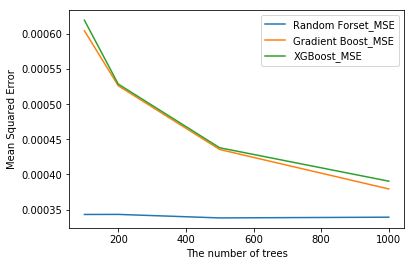

In [33]:
# Show the results of all three techniques in a single graph.
import matplotlib.pyplot as plt
tree_n = [100,200,500,1000]

plt.plot(tree_n, rf_mse, label='Random Forset_MSE')
plt.plot(tree_n, gb_mse, label='Gradient Boost_MSE')
plt.plot(tree_n, xgb_mse, label='XGBoost_MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('The number of trees')
plt.legend()
plt.show()